# Leveraging Original Data Signals: Boosting Predictive Performance in Synthetic Kaggle Competitions

## Important note about the notebook

This notebook is based on the [original work](https://www.kaggle.com/code/cdeotte/use-original-data-for-cv-boost-and-lb-boost/notebook) by [Chris Deotte](https://www.kaggle.com/cdeotte) on the [Backpack Prediction Challenge](https://www.kaggle.com/competitions/playground-series-s5e2).
I've added explanatory comments and analysis to better understand the approach of leveraging original data to improve predictions on synthetic competition data.

This notebook is for educational purposes and documents my learning process in understanding advanced feature engineering techniques.

## Introdution

In this competition, we're tasked with predicting the price of backpacks based on feature like brand, material, size, compartments, laptop comparment capability, waterproofing, style, color, and weight capacity. On first sight appear to be a standard regression problem, but there are some difficulties given the nature of the data.

The original [dataset](https://www.kaggle.com/datasets/souradippal/student-bag-price-prediction-dataset) began with 50,000 uniques entries. The competition creator then:

1. Duplicated 5% of the original entries (2,500 rows)
2. Added controlled noise to numeric features:
    - Compartments: Random integer from uniform distribution [-1, 2)
    - Weight Capacity: Random value from uniform distribution [-2, 2]
    - Price: Noise factor of 0.1 applied through uniform distribution

You can get more information about this process in this [notebook](https://www.kaggle.com/code/souradippal/code-i-used-to-create-this-dataset-6-months-back) and also in the [forum](https://www.kaggle.com/competitions/playground-series-s5e2/discussion/563726).

Additionally, a massive expansion dataset (~3.7 million entries) was created by generating approximately 80 synthetic variations of each original row, with small tweaks to values while preserving the underlying patterns.

What we are going to do in this notebook is to exploit the original-synthetic relationship. Using the feature `Weight Capacity (kg)` as a bridge between the original data set and the synthetic one, we discovered a correlation coefficient of 0.3 betweeen the original prices and the synthetic prices.
![](image.png)

Incorporating the mapping of the original prices into the expanded data as a numerical predictor results in a significant advantage.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [6]:
# LOADING DATA
train = pd.read_csv("train.csv").drop("id", axis=1)
train_extra = pd.read_csv("training_extra.csv").drop("id", axis=1)
original = pd.read_csv("Noisy_Student_Bag_Price_Prediction_Dataset.csv")
test = pd.read_csv("test.csv")
print(f"Original shape: {original.shape}\nTrain shape: {train.shape}\nTrain_Extra shape: {train_extra.shape}")
train.head()

Original shape: (52500, 10)
Train shape: (300000, 10)
Train_Extra shape: (3694318, 10)


,Brand,Material,Size,Compartments,Laptop Compartment,Waterproof,Style,Color,Weight Capacity (kg),Price
0,Jansport,Leather,Medium,7.0,Yes,No,Tote,Black,11.611723,112.15875
1,Jansport,Canvas,Small,10.0,Yes,Yes,Messenger,Green,27.078537,68.88056
2,Under Armour,Leather,Small,2.0,Yes,No,Messenger,Red,16.643760,39.17320
3,Nike,Nylon,Small,8.0,Yes,No,Messenger,Green,12.937220,80.60793
4,Adidas,Canvas,Medium,1.0,Yes,Yes,Messenger,Green,17.749338,86.02312


In [7]:
# CONCATENATE TRAIN AND TRAIN EXTRA
train = pd.concat([train, train_extra], axis=0)

## Find the relationship between original and synthetic data 

In [8]:
# CREATE A MAPPING BETWEEN WEIGHT CAPACITY AND TARGET FROM ORIGINAL SET
# WE ARE USING WEIGHT CAPACITY AS A BRIDGE TO CONNECT ORIGINAL DATA AND SYNTHETIC

map_weight_target = original.groupby("Weight Capacity (kg)")["Price"].mean()
map_weight_target.name = "map_target"

In [9]:
map_weight_target.head()

Weight Capacity (kg)
5.000000     80.693646
5.001061     93.862638
5.004444    130.627948
5.004837     76.920155
5.005468    101.682464
Name: map_target, dtype: float64

In [10]:
# ADD THE MAP WEIGHT TARGET TO THE TRAIN AND TEST SET AS FEATURE
# FOR EACH BAG WITH A WEIGHT CAPACITY IS GOING TO BE AN AVERAGE PRICE FROM THE ORIGINAL DATA

train = train.merge(map_weight_target, on="Weight Capacity (kg)", how="left")
test =  test.merge(map_weight_target, on="Weight Capacity (kg)", how="left")

In [11]:
# RELATIONSHIP BETWEEN SYNTHETIC PRICES AND ORIGINAL PRICES
# FILTER ONLY WEIGHT CAPACITY ENTRIES WITH MORE THAN 100 DATA POINTS AND NON MISSING VALUES

tmp = train.groupby("Weight Capacity (kg)")[["Price", "map_target"]].agg(["mean", "count"])
tmp = tmp.iloc[:, :-1]
tmp.columns = ["Price", "count", "map orig price"]
tmp = tmp.loc[(tmp['count']>100)&(~tmp["map orig price"].isna())]
print(tmp.shape)
tmp.head()

(3660, 3)


,Price,count,map orig price
Weight Capacity (kg),,,
5.000000,78.129020,58087,80.693646
5.936885,70.889343,126,43.384706
6.037197,77.639167,164,49.911285
6.049765,74.313717,149,26.110312
6.050151,79.575370,318,111.551165


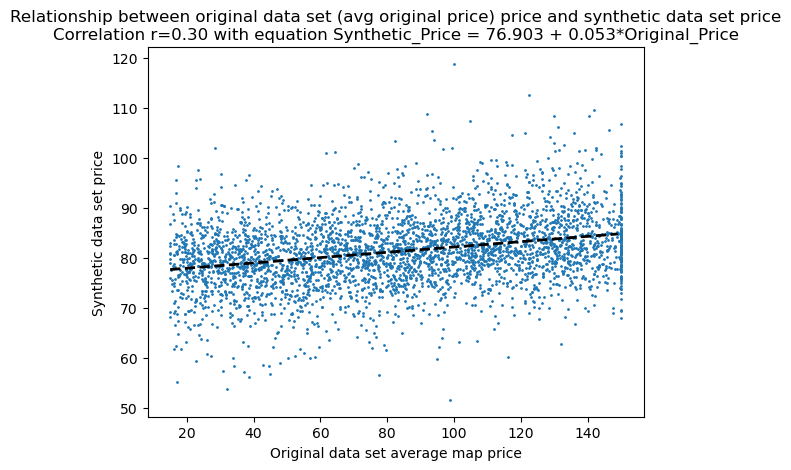

In [12]:
plt.scatter(tmp["map orig price"], tmp["Price"], s=1)
# a slope, b intercept, deg = 1 straight line
a, b = np.polyfit(tmp["map orig price"], tmp["Price"], deg=1)
# min, max from map orig price
x = np.arange(15, 150)
y = b+a*x
plt.plot(x, y, "--", color="black", linewidth=2)
# Pearson correlation btw Price and map orig price
r = np.corrcoef(tmp["Price"], tmp["map orig price"])[0,1]
plt.xlabel("Original data set average map price")
plt.ylabel("Synthetic data set price")
plt.title(
    f"Relationship between original data set (avg original price) price and synthetic data set price\n"
    f"Correlation r={r:.2f} with equation Synthetic_Price = {b:.3f} + {a:.3f}*Original_Price"
         )
plt.show()

A correlation coefficient of 0.3 indicates a positive but weak linear relationship between the original prices and the synthetic prices. This means that, on average, when the original price is higher, the synthetic price also tend to be higher. Despite this relatively weak correlation, it's still valuable information. When you add the original price as a feature in your model, you are giving it access to information that has a relationship with the target variable. 

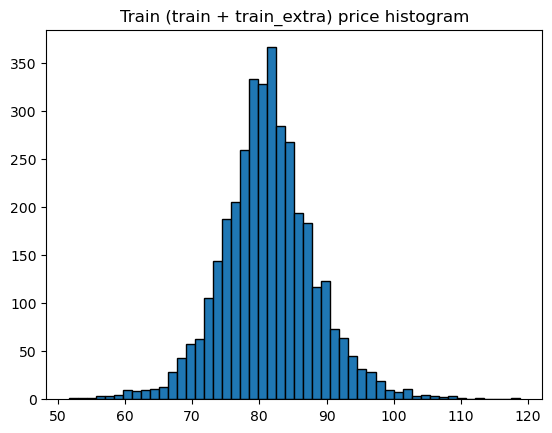

In [13]:
plt.hist(tmp["Price"], bins = 50, edgecolor="black")
plt.title("Train (train + train_extra) price histogram");

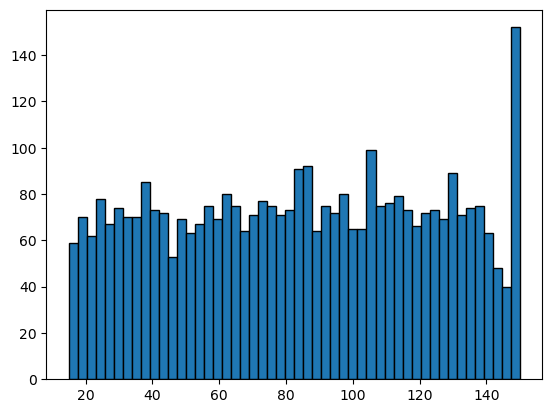

In [14]:
plt.hist(tmp["map orig price"], bins = 50, edgecolor="black");

When the author of this dataset generated the data by duplicating original rows and adding noise, they were basicalliy doing something like this:
```
synthetic_value = original_value + random_noise
```
We can see that the original distribution of prices is a uniform distribution. If you roll a die (represeting random noise) and add and subtract that random values from each price, the resulting distribution will be more concentrated toward the middle, getting the variable a normalization effect. This is because there are more ways to get middle values than extreme ones. The middle values are more "neighboring" original values that can reach them through noise addition. Extreme value, on contrast, have fewer neighbors that can reach them since they are at the edge of the distribution. 


In [15]:
## Addding the "new feature"

In [16]:
# FILTER WEIGHT CAPACITY > 5 AND WEIGHT CAPACITY < 30
tmp_orig = original.loc[(original["Weight Capacity (kg)"]>5) & (original["Weight Capacity (kg)"]<30)]
tmp_orig.columns = [f"orig_{col}" for col in tmp_orig.columns]

In [17]:
tmp_orig.columns

Index(['orig_Brand', 'orig_Material', 'orig_Size', 'orig_Compartments',
       'orig_Laptop Compartment', 'orig_Waterproof', 'orig_Style',
       'orig_Color', 'orig_Weight Capacity (kg)', 'orig_Price'],
      dtype='object')

The merge is performed using "Weight Capacity (kg)" as the bridge between the synthetic and original dataset. The how="left" parameter ensures that all rows from the training and test dataset are kept, even if they don't have a match in the original dataset. 

In [18]:
# ADDING FEATURE TO THE TRAINING AND TESTING SET
train = train.merge(tmp_orig.iloc[:, :-1], left_on="Weight Capacity (kg)", right_on="orig_Weight Capacity (kg)", how="left")
test = test.merge(tmp_orig.iloc[:, :-1], left_on="Weight Capacity (kg)", right_on="orig_Weight Capacity (kg)", how="left")

In [19]:
CATS = train.select_dtypes("object").columns.tolist()
# NUMERICAL FEATURES: WEIGHT CAPACITY AND MAP ORIGINAL TARGET PRICE
NUMS = ["Weight Capacity (kg)", "map_target"]
FEATURES = CATS + NUMS
TARGET = "Price"

In [20]:
from sklearn.model_selection import KFold
from xgboost import XGBRegressor
import xgboost as xgb
print(f"XBoost version is {xgb.__version__}")

XBoost version is 2.1.4


In [21]:
FOLDS = 7

kf = KFold(n_splits=FOLDS, shuffle=True, random_state=42)

oof = np.zeros((len(train)))
pred = np.zeros((len(test)))

for i, (train_idx, valid_idx) in enumerate(kf.split(train)):
    print(f"###### FOLD {i+1} ######")
    X_train = train.loc[train_idx, FEATURES]
    y_train = train.loc[train_idx, TARGET]
    X_valid = train.loc[valid_idx, FEATURES]
    y_valid = train.loc[valid_idx, TARGET]
    X_test = test[FEATURES].copy()

    # CONVERT OBJECT TO CATEGORICAL
    X_train[CATS] = X_train[CATS].astype("category")
    X_valid[CATS] = X_valid[CATS].astype("category")
    X_test[CATS] = X_test[CATS].astype("category")

    # MODEL
    model = XGBRegressor(
        device="cuda",
        max_depth = 6,
        colsample_bytree = 0.5, 
        subsample = 0.8,
        n_estimators = 10000,
        learning_rate = 0.2,
        enable_categorical = True,
        min_child_weight = 10,
        early_stopping_rounds = 100
    )
    # TRAINING
    model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=100)
    # PREDICTIONS (OOF AND TEST)
    oof[valid_idx] = model.predict(X_valid)
    pred += model.predict(X_test)
pred/=FOLDS

###### FOLD 1 ######
[0]	validation_0-rmse:38.90413
[100]	validation_0-rmse:38.78834
[200]	validation_0-rmse:38.77433
[300]	validation_0-rmse:38.76429
[400]	validation_0-rmse:38.75980
[500]	validation_0-rmse:38.75724
[600]	validation_0-rmse:38.75603
[700]	validation_0-rmse:38.75640
[752]	validation_0-rmse:38.75749
###### FOLD 2 ######
[0]	validation_0-rmse:38.90017
[100]	validation_0-rmse:38.78426
[200]	validation_0-rmse:38.76836
[300]	validation_0-rmse:38.76090
[400]	validation_0-rmse:38.75731
[500]	validation_0-rmse:38.75668
[553]	validation_0-rmse:38.75646
###### FOLD 3 ######
[0]	validation_0-rmse:38.92033
[100]	validation_0-rmse:38.80049
[200]	validation_0-rmse:38.78641
[300]	validation_0-rmse:38.77654
[400]	validation_0-rmse:38.77207
[500]	validation_0-rmse:38.77027
[600]	validation_0-rmse:38.76756
[700]	validation_0-rmse:38.76714
[710]	validation_0-rmse:38.76739
###### FOLD 4 ######
[0]	validation_0-rmse:38.96053
[100]	validation_0-rmse:38.84387
[200]	validation_0-rmse:38.82972


In [22]:
# COMPUTE OVERALL CV SCORE
true = train[TARGET].values
rmse = np.sqrt(np.mean((oof - true)**2))
print(f">>>> Overall CV Score is {rmse:.3f}")

>>>> Overall CV Score is 38.783


1. (base score) >> 38.786

In [23]:
# SAVE OOF 
np.save("oof", oof)
print("Saved oof to disk")

Saved oof to disk


In [24]:
print(f"We use {len(FEATURES)} features:")
print(FEATURES)

We use 16 features:
['Brand', 'Material', 'Size', 'Laptop Compartment', 'Waterproof', 'Style', 'Color', 'orig_Brand', 'orig_Material', 'orig_Size', 'orig_Laptop Compartment', 'orig_Waterproof', 'orig_Style', 'orig_Color', 'Weight Capacity (kg)', 'map_target']


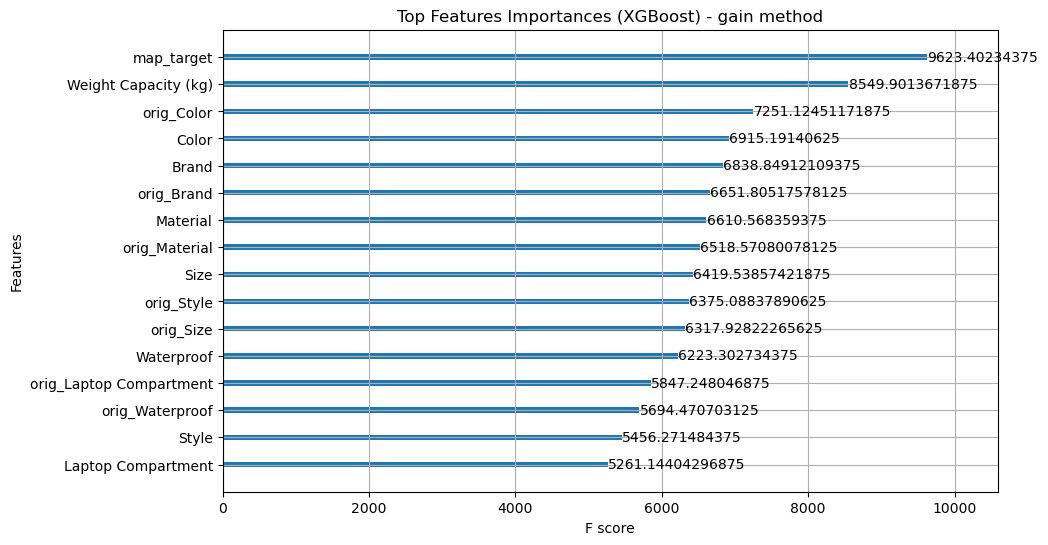

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=100, importance_type="gain", ax=ax)
plt.title("Top Features Importances (XGBoost) - gain method")
plt.show()

In [27]:
sub = pd.read_csv("sample_submission.csv")
sub.Price = pred
sub.to_csv(f"submission.csv", index = True)
sub.head()

,id,Price
0,300000,78.188453
1,300001,82.121694
2,300002,85.787319
3,300003,84.620650
4,300004,79.913192
